In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller1 import player_controller
from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [30]:
def run_algorithm_a(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1):
	"""
	Runs Genetic Algorithm A with the provided environment and parameters.

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""
	n_hidden_neurons_1 = 10
	n_hidden_neurons_2 = 5

	n_vars = (
		(env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
		(n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
		(n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
	)
	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=5):
		selected = []
		for _ in range(len(population)):
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

	# Uniform Crossover
	def crossover(parent1, parent2):
		mask = np.random.rand(n_vars) < 0.5
		child1 = np.where(mask, parent1, parent2)
		child2 = np.where(mask, parent2, parent1)
		return child1, child2

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Record fitness over generations
	history_mean = []
	history_max = []

	# Genetic Algorithm Loop
	for generation in range(1, gens + 1):
		# Selection
		selected = tournament_selection(population, fitness)

		# Crossover
		offspring = []
		for i in range(0, npopulation, 2):
			parent1, parent2 = selected[i], selected[i+1]
			child1, child2 = crossover(parent1, parent2)
			offspring.extend([child1, child2])
		offspring = np.array(offspring)[:npopulation]

		# Mutation
		offspring = np.array([mutate(child) for child in offspring])

		# Evaluation
		offspring_fitness = evaluate(offspring)

		# Replacement: Elitism (keep the best individual) (Could maybe change this)
		best_idx = np.argmax(fitness)
		worst_idx = np.argmin(offspring_fitness)
		if fitness[best_idx] > offspring_fitness[worst_idx]:
			offspring[worst_idx] = population[best_idx]
			offspring_fitness[worst_idx] = fitness[best_idx]
		
		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	np.savetxt(('best_solution_a.txt'), best_solution)

	return history_mean, history_max, best_solution

In [31]:
def run_algorithm_b(env, npopulation=200, gens=30, mutation_rate=0.05, dom_u=1, dom_l=-1, elitism_count=2, share_alpha=0.1, share_sigma=0.2):
	"""
	Runs Genetic Algorithm B (GA with Fitness Sharing for diversity maintenance).

	Parameters:
	- env: Evoman Environment instance.
	- npopulation: Population size.
	- gens: Number of generations.
	- mutation_rate: Mutation rate.
	- dom_u: Upper bound for gene values.
	- dom_l: Lower bound for gene values.
	- elitism_count: Number of elites to preserve.
	- share_alpha: Sharing coefficient.
	- share_sigma: Sharing radius.

	Returns:
	- history_mean: List of mean fitness per generation.
	- history_max: List of max fitness per generation.
	- best_solution: Best solution found.
	"""

	n_hidden_neurons_1 = 10
	n_hidden_neurons_2 = 5

	n_vars = (
		(env.get_num_sensors() + 1) * n_hidden_neurons_1 +  # Weights and biases from input -> hidden layer 1
		(n_hidden_neurons_1 + 1) * n_hidden_neurons_2 +  # Weights and biases from hidden layer 1 -> hidden layer 2
		(n_hidden_neurons_2 + 1) * 5  # Weights and biases from hidden layer 2 -> output layer (5 actions)
	)

	# Run the simulation and return the fitness
	def simulate(x):
		f, _, _, _ = env.play(pcont=x)
		return f

	# Evaluate the current population
	def evaluate(population):
		return np.array([simulate(individual) for individual in population])

	# Tournament Selection
	def tournament_selection(population, fitness, k=5):
		selected = []
		for _ in range(len(population)):
			contenders = np.random.choice(len(population), k, replace=False)
			winner = contenders[np.argmax(fitness[contenders])]
			selected.append(population[winner])
		return np.array(selected)

	# Two-Point Crossover
	def two_point_crossover(parent1, parent2):
		point1 = np.random.randint(0, n_vars)
		point2 = np.random.randint(point1, n_vars)
		child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
		child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
		return child1, child2

	# Gaussian Mutation
	def mutate(child):
		for i in range(n_vars):
			if np.random.rand() < mutation_rate:
				child[i] += np.random.normal(0, 0.1)
				child[i] = np.clip(child[i], dom_l, dom_u)
		return child

	# Fitness Sharing
	def fitness_sharing(population, fitness, alpha, sigma):
		"""
		Adjusts fitness based on similarity using fitness sharing.

		Parameters:
		- population: Current population.
		- fitness: Original fitness values.
		- alpha: Sharing coefficient.
		- sigma: Sharing radius.

		Returns:
		- shared_fitness: Adjusted fitness values.
		"""
		shared_fitness = np.copy(fitness)
		npop = population.shape[0]
		for i in range(npop):
			for j in range(npop):
				if i != j:
					distance = np.linalg.norm(population[i] - population[j])
					if distance < sigma:
						shared_fitness[i] -= alpha * (1 - distance / sigma)
		# Ensure that fitness doesn't become negative
		shared_fitness = np.maximum(shared_fitness, 0)
		return shared_fitness

	# Initialize population
	population = np.random.uniform(dom_l, dom_u, (npopulation, n_vars))
	fitness = evaluate(population)

	# Apply Fitness Sharing
	fitness = fitness_sharing(population, fitness, share_alpha, share_sigma)

	# Record fitness over generations
	history_mean = []
	history_max = []

	# Genetic Algorithm Loop
	for generation in range(1, gens + 1):
		# Selection
		selected = tournament_selection(population, fitness)

		# Crossover
		offspring = []
		for i in range(0, npopulation, 2):
			parent1, parent2 = selected[i], selected[i+1]
			child1, child2 = two_point_crossover(parent1, parent2)
			offspring.extend([child1, child2])
		offspring = np.array(offspring)[:npopulation]

		# Mutation
		offspring = np.array([mutate(child) for child in offspring])

		# Evaluation
		offspring_fitness = evaluate(offspring)

		# Apply Fitness Sharing
		offspring_fitness = fitness_sharing(offspring, offspring_fitness, share_alpha, share_sigma)

		# Replacement: Elitism (keep the best individual) (Could maybe change this)
		best_idx = np.argmax(fitness)
		worst_idx = np.argmin(offspring_fitness)
		if fitness[best_idx] > offspring_fitness[worst_idx]:
			offspring[worst_idx] = population[best_idx]
			offspring_fitness[worst_idx] = fitness[best_idx]

		population, fitness = offspring, offspring_fitness

		# Record statistics
		history_mean.append(np.mean(fitness))
		history_max.append(np.max(fitness))

		# Logging
		print(f'Generation {generation}: Best Fitness = {history_max[-1]:.4f}, Mean Fitness = {history_mean[-1]:.4f}')

	# Get best solution
	best_idx = np.argmax(fitness)
	best_solution = population[best_idx]

	np.savetxt(('best_solution_b.txt'), best_solution)

	return history_mean, history_max, best_solution

In [32]:
# Experiment Parameters
enemy = 6
num_runs = 2  			# Change to 10 for full experiment
npopulation = 200
gens = 10 				# Change to 30 for full experiment
mutation_rate = 0.05
dom_u, dom_l = 1, -1
elitism_count_a = 1  	# For Algorithm A
elitism_count_b = 2  	# For Algorithm B
n_hidden1 = 10
n_hidden2 = 5


# Initialize data storage
results = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Generation': [],
    'Mean Fitness': [],
    'Max Fitness': [],
    'Best Solution': []
}

best_solutions = {
    'Algorithm': [],
    'Enemy': [],
    'Run': [],
    'Best Solution': []
}

In [33]:
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5

for run in range(1, num_runs + 1):
	print(f"Run {run}/{num_runs}")
	
	# Define experiment names for Algorithm A and B
	experiment_name_a = f'optimization_test_a_run_{run}'
	experiment_name_b = f'optimization_test_b_run_{run}'
	
	# Create directories for Algorithm A and B
	os.makedirs(experiment_name_a, exist_ok=True)
	os.makedirs(experiment_name_b, exist_ok=True)
	
	# Initialize Environment for Algorithm A
	env_a = Environment(
		experiment_name=experiment_name_a,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
		enemymode="static",
		level=2,
		speed="fastest",
		visuals=False
	)
	
	# Run Algorithm A
	mean_a, max_a, best_a = run_algorithm_a(
		env=env_a,
		npopulation=npopulation,
		gens=gens,
		mutation_rate=mutation_rate,
		dom_u=dom_u,
		dom_l=dom_l
	)
	
	# Record data for Algorithm A
	for gen in range(1, gens + 1):
		results['Algorithm'].append('A')
		results['Enemy'].append(enemy)
		results['Run'].append(run)
		results['Generation'].append(gen)
		results['Mean Fitness'].append(mean_a[gen - 1])
		results['Max Fitness'].append(max_a[gen - 1])
		results['Best Solution'].append(best_a)
	
	best_solutions['Algorithm'].append('A')
	best_solutions['Enemy'].append(enemy)
	best_solutions['Run'].append(run)
	best_solutions['Best Solution'].append(best_a)
	
	
	# Initialize Environment for Algorithm B
	env_b = Environment(
		experiment_name=experiment_name_b,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden_neurons_1, n_hidden_neurons_2),
		enemymode="static",
		level=2,
		speed="fastest",
		visuals=False
	)
	
	# Run Algorithm B
	mean_b, max_b, best_b = run_algorithm_b(
		env=env_b,
		npopulation=npopulation,
		gens=gens,
		mutation_rate=mutation_rate,
		dom_u=dom_u,
		dom_l=dom_l,
		elitism_count=elitism_count_b
	)
	
	# Record data for Algorithm B
	for gen in range(1, gens + 1):
		results['Algorithm'].append('B')
		results['Enemy'].append(enemy)
		results['Run'].append(run)
		results['Generation'].append(gen)
		results['Mean Fitness'].append(mean_b[gen - 1])
		results['Max Fitness'].append(max_b[gen - 1])
		results['Best Solution'].append(best_b)
	
	best_solutions['Algorithm'].append('B')
	best_solutions['Enemy'].append(enemy)
	best_solutions['Run'].append(run)
	best_solutions['Best Solution'].append(best_b)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

best_solutions_df = pd.DataFrame(best_solutions)
best_solutions_df.to_csv('best_solutions.csv', index=False)


Run 1/2

MESSAGE: Pygame initialized for simulation.
Generation 1: Best Fitness = 21.9062, Mean Fitness = -1.6853
Generation 2: Best Fitness = 57.3370, Mean Fitness = 3.0727
Generation 3: Best Fitness = 57.3370, Mean Fitness = 8.4597
Generation 4: Best Fitness = 57.3370, Mean Fitness = 12.5919
Generation 5: Best Fitness = 57.3370, Mean Fitness = 16.5149
Generation 6: Best Fitness = 57.3370, Mean Fitness = 14.6456
Generation 7: Best Fitness = 57.4317, Mean Fitness = 17.8463
Generation 8: Best Fitness = 57.4317, Mean Fitness = 16.4272
Generation 9: Best Fitness = 57.4317, Mean Fitness = 18.2747
Generation 10: Best Fitness = 57.4317, Mean Fitness = 18.5984

MESSAGE: Pygame initialized for simulation.
Generation 1: Best Fitness = 57.5447, Mean Fitness = 4.5038
Generation 2: Best Fitness = 57.5447, Mean Fitness = 9.8466
Generation 3: Best Fitness = 57.5447, Mean Fitness = 16.0457
Generation 4: Best Fitness = 57.5447, Mean Fitness = 17.9705
Generation 5: Best Fitness = 57.5533, Mean Fitness 

In [34]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = results_df.groupby(['Algorithm', 'Enemy', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std')
).reset_index()

In [35]:
# Display the first few rows of the grouped data
grouped.head()

,Algorithm,Enemy,Generation,mean_fitness_mean,mean_fitness_std,max_fitness_mean,max_fitness_std
0,A,6,1,-1.317175,0.520549,48.613039,37.769103
1,A,6,2,3.149377,0.108474,66.328433,12.715751
2,A,6,3,8.706840,0.349448,66.328433,12.715751
3,A,6,4,12.016020,0.814450,66.328433,12.715751
4,A,6,5,15.361270,1.631520,66.328433,12.715751


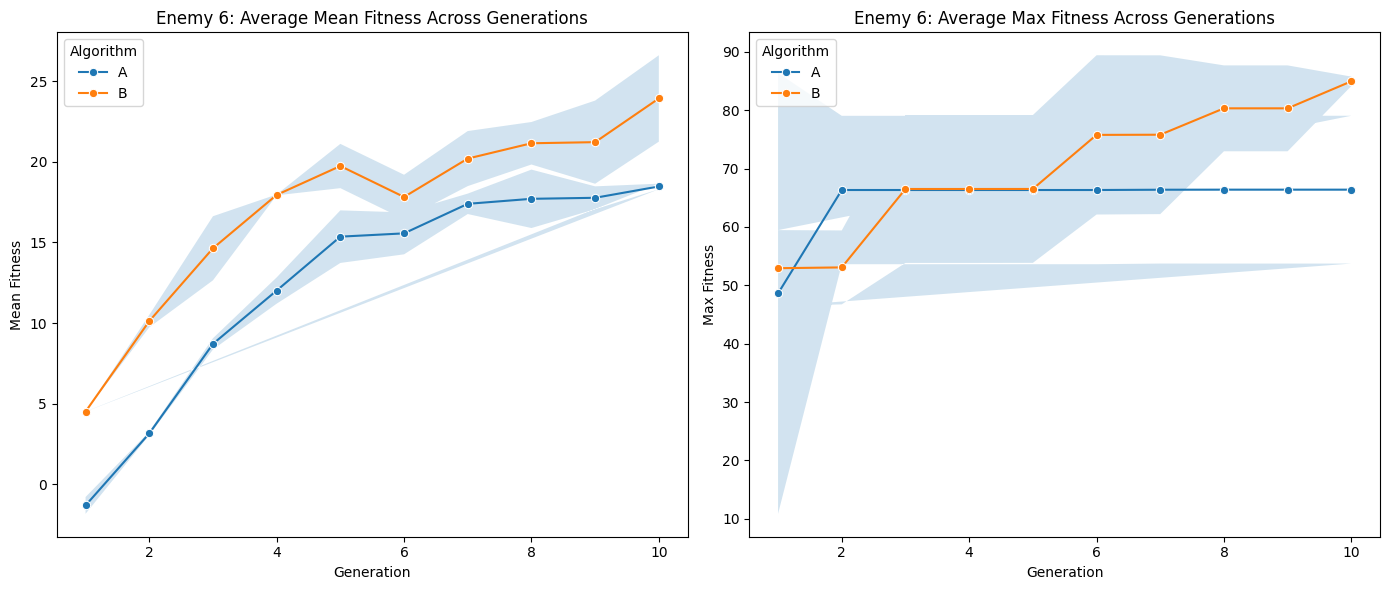

In [36]:
plt.figure(figsize=(14, 6))

# Subset data for the current enemy
data_enemy = grouped[grouped['Enemy'] == enemy]

# Plot Mean Fitness
plt.subplot(1, 2, 1)
sns.lineplot(data=data_enemy, x='Generation', y='mean_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['mean_fitness_mean'] - data_enemy['mean_fitness_std'],
	data_enemy['mean_fitness_mean'] + data_enemy['mean_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Mean Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.legend(title='Algorithm')

# Plot Max Fitness
plt.subplot(1, 2, 2)
sns.lineplot(data=data_enemy, x='Generation', y='max_fitness_mean', hue='Algorithm', marker='o')
plt.fill_between(
	data_enemy['Generation'],
	data_enemy['max_fitness_mean'] - data_enemy['max_fitness_std'],
	data_enemy['max_fitness_mean'] + data_enemy['max_fitness_std'],
	alpha=0.2
)
plt.title(f'Enemy {enemy}: Average Max Fitness Across Generations')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.legend(title='Algorithm')

plt.tight_layout()
plt.show()


# TODO: Run the best solution on 2 other enemies

In [39]:
enemies = [1, 6, 8]

experiment_name = 'test_other_enemies'
os.makedirs(experiment_name, exist_ok=True)

# Load best solutions
best_solutions_a = np.loadtxt('best_solution_b.txt')

n_hidden1 = 10
n_hidden2 = 5

for enemy in enemies:
	env = Environment(
		experiment_name=experiment_name,
		enemies=[enemy],
		playermode="ai",
		player_controller=player_controller(n_hidden1, n_hidden2),
		enemymode="static",
		level=2,
		speed="normal",
		visuals=True
	)

	f, _, _, _ = env.play(pcont=best_solutions_a)

	print(f'Enemy {enemy}: Fitness = {f:.4f}')


MESSAGE: Pygame initialized for simulation.
Enemy 1: Fitness = 21.2538

MESSAGE: Pygame initialized for simulation.
Enemy 6: Fitness = 85.5277

MESSAGE: Pygame initialized for simulation.
Enemy 8: Fitness = 48.0494


# TODO: Fix Gain
